In [60]:
from  astropy.io import fits

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import glob
from datetime import datetime


In [61]:
### Organize a sequence of NRES spectras into a dict:
# dict['filenmame'] = {'wavelength': wavelength, 'normflux': normflux, 'dataobs': dataobs}

spectrumdata = {}

def interpolate_nres_spectrum (filename, plot = False, barycorrect = False):
    """
    Read a NRES spectrum from a file.
    
    Parameters
    ----------
    filename : str
        The name of the file to read.
    
      Returns
    -------
    """

    with fits.open(filename) as hdu:  
      data = hdu["SPECTRUM"].data
      data = data[data['fiber']!=1]   
      wavelength = data['wavelength']
      normflux = data['normflux']
      order = data['order']

      dateobs = hdu[0].header['DATE-OBS']
      dateobs = datetime.strptime(dateobs, '%Y-%m-%dT%H:%M:%S.%f')
      rv = hdu[0].header['RV']
      barrycorr = hdu[0].header['BARYCORR']
      print (f"dateobs: {dateobs}   rv: {rv} barycorr: {barrycorr}")

      grid_wavelength = np.arange(3700, 9500, 0.1)
      grid_normflux = grid_wavelength * 0.

      for  ii, myorder  in enumerate(order):       
        wavelength_order = wavelength[ii] 
        normflux_order = normflux[ii]

        good = (wavelength_order > 0) & (normflux_order > 0) & (wavelength_order < 10000) & (normflux_order < 10000)
        wavelength_order = wavelength_order[good]
        normflux_order = normflux_order[good]
        model = interp1d(wavelength_order, normflux_order, kind="cubic", bounds_error=False)
  
        min_lambda = np.min(wavelength_order)
        max_lambda = np.max(wavelength_order)
        firstindex = np.argmax(min_lambda)

        while ( (firstindex < len(grid_normflux)) &(grid_wavelength[firstindex] < max_lambda)):
          grid_normflux[firstindex] = model(grid_wavelength[firstindex])
          firstindex += 1
          
    if barycorrect:
      vc = barrycorr / 2.998e+8
      grid_wavelength = grid_wavelength * (1 -vc / (1+vc))


    if plot:
      fig, ax = plt.subplots()       
      ax.plot(grid_wavelength, grid_normflux, linewidth=1, label=f"interpolated")     
      ax.set_ylabel("normflux")
      ax.set_xlabel("wavelength")
   
      plt.legend()
      hdu.close()
      plt.savefig(f"nres_spectrum{dateobs}.pdf", dpi=300)
    
    returndict = {'dateobs':dateobs, 
                  'wavelength': grid_wavelength, 
                  'normflux':grid_normflux,
                  'rv': rv,
                  'barycorr': barrycorr,}
    
    return (returndict)

singedatum = interpolate_nres_spectrum("lco_data-20250326-4/cptnrs03-fa13-20250326-0016-e92-1d.fits.fz")

dateobs: 2025-03-26 18:03:38.467000   rv: 9628.45626166989 barycorr: -1985.1937383292188


In [62]:
files = glob.glob("spectra/*-1d.fits.fz")
myspectra = {}
for filename in files:
    print (filename)
    dataset = interpolate_nres_spectrum(filename, barycorrect=True, plot=False)
                                        
    dateobs = dataset['dateobs']
    dataset['filename'] = filename
    myspectra[dateobs] = dataset

spectra/cptnrs03-fa13-20250328-0017-e92-1d.fits.fz
dateobs: 2025-03-28 19:41:40.409000   rv: 27614.78546620921 barycorr: -1977.4526290308345
spectra/cptnrs03-fa13-20250327-0019-e92-1d.fits.fz
dateobs: 2025-03-27 19:22:21.366000   rv: 19900.3481275792 barycorr: -1999.5566343278826
spectra/cptnrs03-fa13-20250326-0016-e92-1d.fits.fz
dateobs: 2025-03-26 18:03:38.467000   rv: 9628.45626166989 barycorr: -1985.1937383292188
spectra/cptnrs03-fa13-20250329-0021-e92-1d.fits.fz
dateobs: 2025-03-29 19:06:47.500000   rv: 25068.028965643327 barycorr: -1932.1615105495932


[datetime.datetime(2025, 3, 26, 18, 3, 38, 467000), datetime.datetime(2025, 3, 27, 19, 22, 21, 366000), datetime.datetime(2025, 3, 28, 19, 41, 40, 409000), datetime.datetime(2025, 3, 29, 19, 6, 47, 500000)]
[datetime.datetime(2025, 3, 26, 18, 3, 38, 467000), datetime.datetime(2025, 3, 27, 19, 22, 21, 366000), datetime.datetime(2025, 3, 28, 19, 41, 40, 409000), datetime.datetime(2025, 3, 29, 19, 6, 47, 500000)]
[datetime.datetime(2025, 3, 26, 18, 3, 38, 467000), datetime.datetime(2025, 3, 27, 19, 22, 21, 366000), datetime.datetime(2025, 3, 28, 19, 41, 40, 409000), datetime.datetime(2025, 3, 29, 19, 6, 47, 500000)]
[datetime.datetime(2025, 3, 26, 18, 3, 38, 467000), datetime.datetime(2025, 3, 27, 19, 22, 21, 366000), datetime.datetime(2025, 3, 28, 19, 41, 40, 409000), datetime.datetime(2025, 3, 29, 19, 6, 47, 500000)]


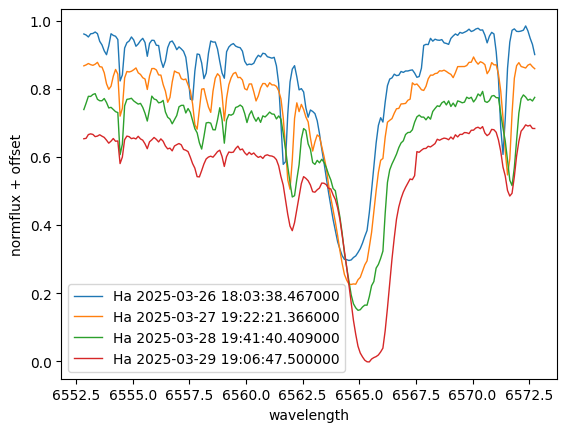

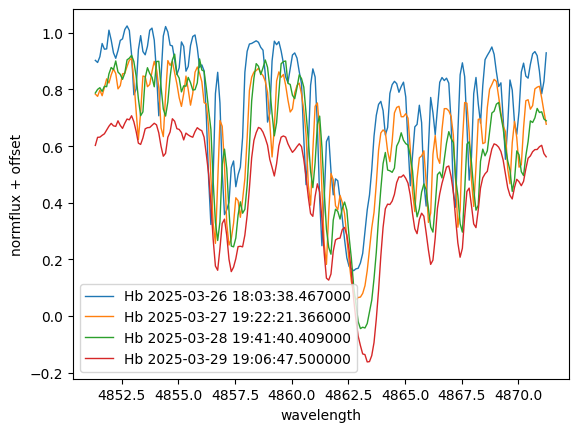

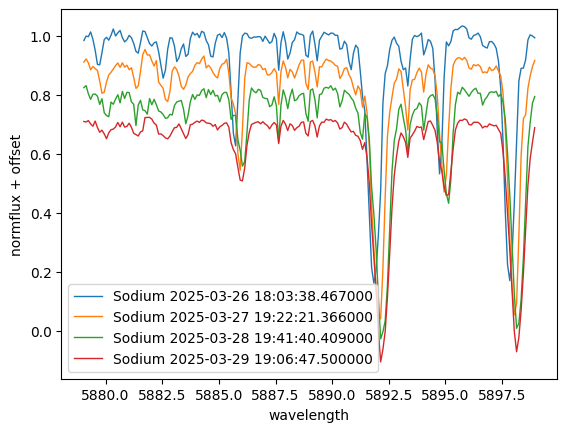

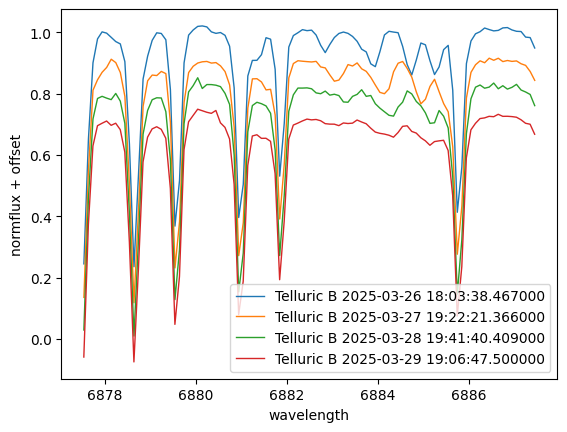

In [ ]:

def plot_single_ha (wave, flux,  center_wavelegnth = 6562.8,  wavelength_range = 20, offset = 0, label="H alpha"):

    wavelength_mask = (wave > center_wavelegnth - wavelength_range) & (wave < center_wavelegnth + wavelength_range)
    plt.plot(wave[wavelength_mask], flux[wavelength_mask] + offset, linewidth=1, label=label)

def plot_fullset (dataset, center_wavelegnth = 6562.8, wavelength_range = 20, label="ha"):
    fig, ax = plt.subplots()
    offset = 0
    ordered = sorted(dataset.keys())
    for key in ordered:
      data = dataset[key]
      dateobs = data['dateobs']
      plot_single_ha (data['wavelength'], data['normflux'], center_wavelegnth = center_wavelegnth, wavelength_range = wavelength_range, offset = offset, label=f"{label} {dateobs}")
      offset -= 0.1

    ax.set_ylabel("normflux + offset")
    ax.set_xlabel("wavelength")
    plt.legend()
    plt.savefig(f"nres_spectrum_{label}.pdf", dpi=300)

plot_fullset(myspectra, center_wavelegnth = 6562.8, wavelength_range=10, label="Ha")
plot_fullset(myspectra, center_wavelegnth = 4861.3, wavelength_range=10, label="Hb")
plot_fullset(myspectra, center_wavelegnth = 5889.0, wavelength_range=10, label="Sodium")
plot_fullset(myspectra, center_wavelegnth = 6882.5, wavelength_range=5, label="Telluric B")




[datetime.datetime(2025, 3, 26, 18, 3, 38, 467000), datetime.datetime(2025, 3, 27, 19, 22, 21, 366000), datetime.datetime(2025, 3, 28, 19, 41, 40, 409000), datetime.datetime(2025, 3, 29, 19, 6, 47, 500000)]


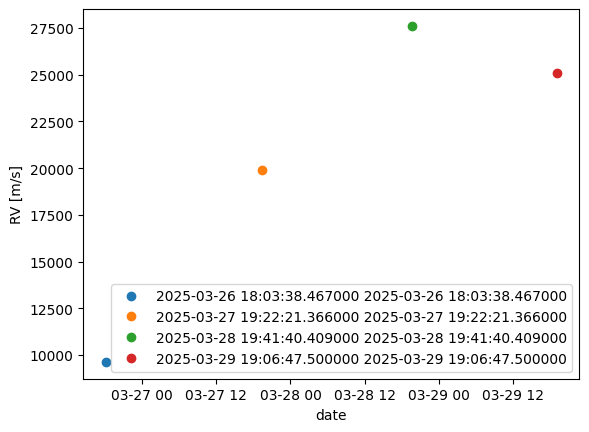

In [64]:
def Plot_rvs(dataset):
    fig, ax = plt.subplots()
    ordered = sorted(dataset.keys())
    print (ordered) 
    for key in ordered:
      data = dataset[key]
      dateobs = data['dateobs']
      rv = data['rv']
      ax.plot(dateobs, rv, 'o', label=f"{key} {dateobs}")

    ax.set_ylabel("RV [m/s]")
    ax.set_xlabel("date")
    plt.legend()
    plt.savefig(f"nres_spectrum_rv.pdf", dpi=300)

Plot_rvs(myspectra)
